# 7: Numerics in Firedrake

Implementing the Godunov scheme as detailed in previous sections.

In [55]:
class River(object):
    def __init__(self, h0: float, w0: float, L: float, Cm: float = 0.1, g: float = 9.81, dsb: float = -0.001):
        self.h0: float = h0  # initial depth (m)
        self.w0: float = w0  # initial width (m)
        self.L: float = L    # length of the river reach (m)
        self.Cm: float = Cm  # Manning's roughness coefficient
        self.g: float = g    # gravitational acceleration (m/s^2)
        self.dsb: float = dsb  # bed slope

    def build_grid(self, nx):
        self.nx: int = nx
        self.dx: float = self.L / (self.nx - 1)
        self.x: list[float] = [i * self.dx for i in range(self.nx)]

    def is_built(self):
        return hasattr(self, 'nx') and hasattr(self, 'dx') and hasattr(self, 'x')
    
    def P(self, A):
        return self.w0 + 2 * A / self.w0

    def flux(self, A):
        return A ** (5/3) * (-1 * self.dsb) ** 0.5 / (self.Cm * self.P(A) ** (2/3))
    
    def velocity(self, A):
        return (A / self.P(A)) ** (2/3) * (-1 * self.dsb) ** 0.5 / self.Cm
    
    def Q(self, A):
        return A * self.velocity(A)

In [86]:

class BoundaryConditions(object):
    def __init__(self, w: list[float], h: list[float], times: list[float]):
        self.w = w
        self.h = h
        self.times = times

class InitialConditions(object):
    def __init__(self, A: list[float], w: list[float], positions: list[float]):
        self.A = A
        self.w = w
        self.positions = positions

class Solution(River):
    def __init__(self, river: River, times: list[float], A: list[list[float]], w: list[list[float]]):
        super().__init__(river.h0, river.w0, river.L, river.Cm, river.g, river.dsb)

        self.times = times
        self.A = A  # 2D list: time x space
        self.w = w  # 2D list: time x space, note that currently it is assumed constant through time

        self.build_grid(river.nx)

    # def plot_deprecated(self):
        # import plotly.express as px
    #     import pandas as pd

    #     assert self.is_built(), "River grid must be built before plotting solution."
        
    #     # Find y limit from maximum and minimum A values
    #     y_min = min([min(a) for a in self.A])
    #     y_max = max([max(a) for a in self.A])

    #     data = pd.DataFrame(columns=['x', 'time', 'A'])
    #     for t_idx, time in enumerate(self.times):
    #         for x_idx, x in enumerate(self.x):
    #             data.loc[len(data)] = {'x': x, 'time': time, 'A': self.A[t_idx][x_idx]}

    #     fig = px.line(data, x='x', y='A', animation_frame='time', title='River Cross-Section')
    #     fig.update_yaxes(range=[y_min, y_max])
    #     fig.show()

    def plot_time(self, time_index: int):
        import matplotlib.pyplot as plt

        assert self.is_built(), "River grid must be built before plotting solution."
        assert 0 <= time_index < len(self.times), "Invalid time index."

        # Convert to hours 
        times_hours = [t / 3600 for t in self.times]

        plt.figure()
        plt.plot(self.x, self.A[time_index], label=f'Time = {times_hours[time_index]:.2f} hours')
        plt.xlabel('Distance along river (m)')
        plt.ylabel('Cross-sectional Area (m²)')
        plt.title('River Cross-Section at Specific Time')
        plt.legend()
        plt.show()

    def plot(self):
        import matplotlib.pyplot as plt
        import numpy as np

        assert self.is_built(), "River grid must be built before plotting solution."

        # Define a colourmap for the times
        cmap = plt.get_cmap('viridis')

        # Convert times to hours
        times_hours = [t / 3600 for t in self.times]
        norm = plt.Normalize(vmin=min(times_hours), vmax=max(times_hours))

        # Take every 10th time step for clarity
        base_figsize = plt.rcParams.get('figure.figsize', (6.4, 4.8))
        plt.figure(figsize=(base_figsize[0]*3, base_figsize[1]))
        for t_idx, time in enumerate(times_hours):
            if t_idx % max(1, len(times_hours)//20) == 0 or t_idx == len(times_hours) - 1:
                plt.plot(self.x, self.A[t_idx], color=cmap(norm(time)), label=f'Time = {time:.2f} hours')
        plt.xlabel('Distance along river (m)')
        plt.ylabel('Cross-sectional Area (m²)')
        plt.title('River Cross-Section Over Time')
        plt.legend()
        plt.show()

class GodunovSolver(object):
    def __init__(self):
        pass

    def solve(self, river: River, bc: BoundaryConditions, ic: InitialConditions, t_final: float, dt: float) -> Solution:
        # If dt = None, compute dt based on CFL condition
        

        times = [0.0]
        A = [ic.A.copy()]
        w = [ic.w.copy()]  # Assuming width is constant for simplicity

        while times[-1] < t_final:
            if len(times) % 10 == 0:
                print("\r", end="")
                print(f"Time: {times[-1]:.2f} / {t_final:.2f} s", end="")
            new_A, new_w = self.iteration(river, A[-1], w[-1], dt, bc.h[int(times[-1]/dt)])  # Using first boundary condition as example
            A.append(new_A)
            w.append(new_w)
            times.append(times[-1] + dt)
        

        return Solution(river, times, A, w)

    def iteration(self, river: River, A: list[float], w: list[float], dt: float, boundary: float):
        # Placeholder for a single iteration of the Godunov method
        new_A = A.copy()
        new_w = w.copy()

        # Assign boundary conditions from argument
        new_A[0] = boundary

        for i in range(1, len(A)):
            # Fluxes for k+1/2 and k-1/2
            F_plus = river.flux(A[i])
            F_minus = river.flux(A[i - 1])

            # Update
            new_A[i] = A[i] - (dt / river.dx) * (F_plus - F_minus)

        return new_A, new_w
            


In [87]:
from typing import Optional
import numpy as np
import math

# Define a initial conditions for constant area and width 
def constant_ic(river: River) -> InitialConditions:
    A0 = river.h0 * river.w0
    A: list[float] = [A0 for _ in range(river.nx)]
    w: list[float] = [river.w0 for _ in range(river.nx)]
    positions: list[float] = river.x.copy()
    return InitialConditions(A, w, positions)

# Define boundary conditions for constant area and width at the upstream end
def constant_bc(river: River, times: list[float], h: Optional[float] = None, w: Optional[float] = None) -> BoundaryConditions:
    if w is not None:
        w0 = w
    else:
        w0 = river.w0
    if h is not None:
        A0 = h * w0
    else:
        A0 = river.h0 * w0
        
    A: list[float] = [A0 for _ in times]
    w: list[float] = [w0 for _ in times]
    return BoundaryConditions(w, A, times)

def flood_bc(river: River, times: list[float], flood_multiple: float, verbosity: int = 0) -> BoundaryConditions:
    w0 = river.w0
    A0 = w0 * river.h0
        
    A: list[float] = [A0 for _ in times] # Base Profile
    w: list[float] = [w0 for _ in times]

    # Set peak_time to be 16 hours in seconds
    peak_time: int = times.index(min(times, key=lambda x: abs(x - 57600)))  # 16 hours = 57600 seconds
    # flood_profile = [A0 * t/times[peak_time] * flood_multiple for t in times[:peak_time + 1]] 
    flood_profile = [A0 * flood_multiple / times[peak_time] * (2 * times[t] - times[t] ** 2 / times[peak_time]) for t in range(peak_time + 1)]
    flood_profile += [A0 * flood_multiple * math.exp((times[peak_time] - t) / (times[peak_time])) for t in times[peak_time + 1:]]

    for i in range(len(A)):
        A[i] = A[i] + flood_profile[i]

    if verbosity > 0:
        # Plot
        import matplotlib.pyplot as plt

        times_hours = [t / 3600 for t in times]  # Convert seconds to hours for plotting
        plt.figure()
        plt.plot(times_hours, A, label='Flood Boundary Condition')
        plt.xlabel('Time (hours)')
        plt.ylabel('Cross-sectional Area (m²)')
        plt.title('Flood Boundary Condition Over Time')
        plt.legend()
        plt.show()
    
    return BoundaryConditions(w, A, times)

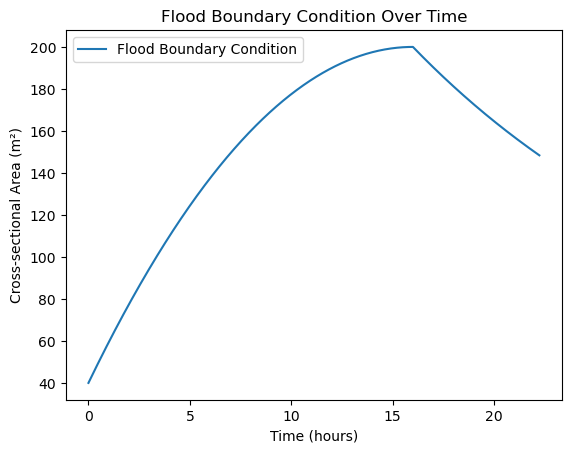

800
Time: 79900.00 / 80000.00 s

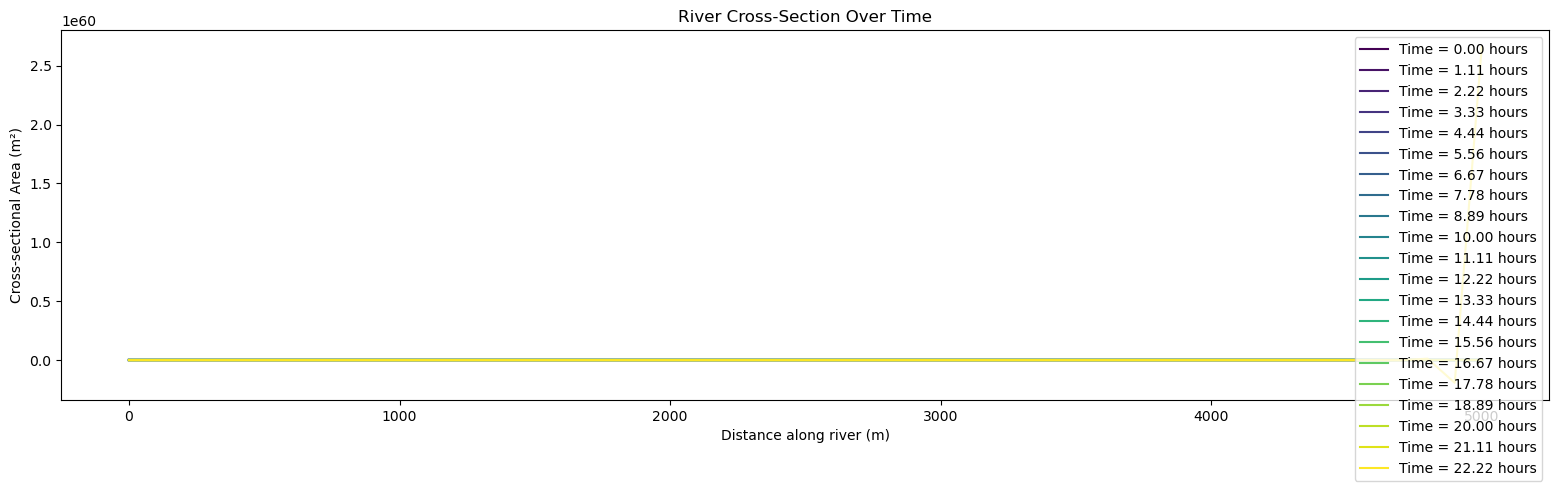

In [96]:

L = 5000
W0 = 40
H0 = 1
dt = 100
t_final = 80000.0
river = River(H0, W0, L)
river.build_grid(nx=51)
ic: InitialConditions = constant_ic(river)
# bc = constant_bc(river, times=[np.linspace(0, t_final, num=2).tolist()], h = 6)
bc: BoundaryConditions = flood_bc(river, times=np.linspace(0, t_final, int(t_final/dt)).tolist(), flood_multiple=4, verbosity=1)
print(len(bc.h))

solver = GodunovSolver()
solution = solver.solve(river, bc, ic, t_final=t_final, dt=dt)

solution.plot()


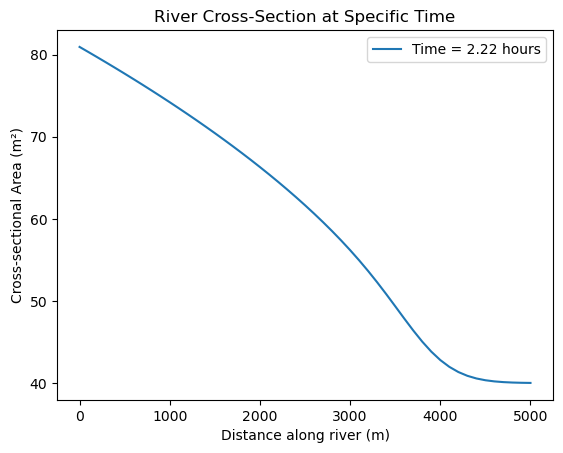

In [101]:
solution.plot_time(time_index=80)

In [90]:
# import time
# print('This is important info!')
# for i in range(100):
#     print("\r"+'Processing BIG data file {}'.format(i),end="")
#     time.sleep(0.1)
#     if i == 50:
#         print("\r"+'Something bad happened on run {}.  This needs to be visible at the end!'.format(i))
# print("\r"+'Done.')